# Helpers


In [0]:
import os, sys, wave, struct

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy
from math import ceil
from scipy.io import wavfile, loadmat

# Needed imports
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile

def load_music(file):
    return wave.open(file, 'rb')

def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
def process_sound(music) :
    '''
    Process Sound
    '''
    wavefile = load_music(music)
    param = wavefile.getparams()

    Fs, data = wavfile.read(music)
    timestep = 1/float(Fs)
    times = np.arange(len(data))*timestep

    return Fs, data, times, param
  
def write_music_1D(file, param, data):
    '''
    Write Music in wav file (mono)
    '''
    wavefile = wave.open(file, 'wb')
    wavefile.setparams(param)
    wavefile.setnframes(len(data))
    wavefile.setnchannels(1)

    for i in range(len(data)):
        v = int(data[i])
        wavefile.writeframesraw( struct.pack('<h', v ) )
    wavefile.writeframes(''.encode())
    wavefile.close()

# 2 Second part

### 2.1 Problem 1: Binaural filtering

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


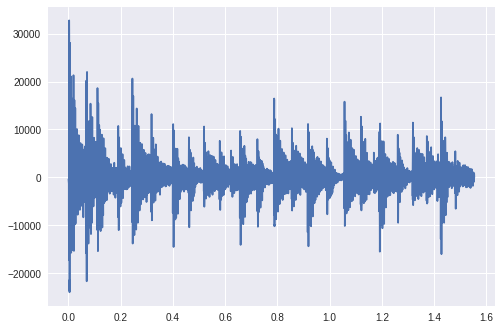

In [3]:
sound = 'drum_roll44.wav'
Fs, data, times, param = process_sound(sound)

plt.plot(times, data)
plt.show()

Audio(data,rate = Fs)

In [0]:
def getNearestUCDpulse(azimuth,elevation,h3D, verbose = False):
  """   
  retrieves the impulse response from h3D that is closest to the specified 
  azimuth and elevation (in degrees)
  h3D is the array containing all HRTFs for a given subject (left or right) 
  """


  elmax = 50
  elindices = np.array(range(elmax))
  elevations = -45 + 5.625*(elindices-1)
  azimuths = np.array( [-80, -65, -55] + list(range(-45,45,5)) + [55, 65, 80] )

  " el est est l'indice du plus proche de l'indicie elevation entre "
  el = np.round ((elevation+45)/5.625 +1)
  el = np.maximum(el,1)
  el = np.minimum(el,elmax).astype(int)
  elerr = el - (elevation+45)/5.625 +1


  "%azim est l'indice du plus proche de l'indice azimuth entre "
  azerr, azim = np.min( (abs(azimuths - azimuth)) ), np.argmin( (abs(azimuths - azimuth)) )


  if verbose:
    print('les parametres utilises pour la HRTF sont:\n \t azimuth: {} degres \n \t elevation: {} degres'.format(azimuths[azim],-45 + 5.625*(el-1)))
    print('\nles indices sont:\n \t azim: {} \n \t el: {} '.format(azim,el))

  pulse = h3D[azim, el, :]

  return pulse,azerr,elerr



#### 2.1.1. Binaural filtering for a fixed position in space

In [5]:
# Choose coordinates and load hrir file
azimuth = -20
elevation = -20
h3D = loadmat('hrir_final.mat')

# compute binaural signals
pulse_l,azerr,elerr = getNearestUCDpulse(azimuth,elevation,h3D['hrir_l'])
pulse_r,azerr,elerr = getNearestUCDpulse(azimuth,elevation,h3D['hrir_r'])

# create binaural sound by convolving mono sound with the binaural filters
l, r = list(np.convolve(data,pulse_l)) , list(np.convolve(data,pulse_r)) 


# Do the same thing for another point in space
azimuth = 20
elevation = 20
h3D = loadmat('hrir_final.mat')

pulse_l,azerr,elerr = getNearestUCDpulse(azimuth,elevation,h3D['hrir_l'])
pulse_r,azerr,elerr = getNearestUCDpulse(azimuth,elevation,h3D['hrir_r'])

l += list(np.convolve(data,pulse_l)) 
r += list(np.convolve(data,pulse_r)) 

Audio([l,r],rate = Fs)

The result is very convincing (at least for me) with the hrir from subject 065.

#### 2.1.2.Binaural filtering for a trajectory

In [6]:
# create continuous trajectory

T = len(data)
t_azimuth = np.linspace(-45,45,T)
t_elevation = np.sin(np.linspace(-45,45,T)/30.)


l, t = np.zeros(T), np.zeros(T)
for t in range(T):
  
  pulse_l,_,__= getNearestUCDpulse(t_azimuth[t],t_elevation[t],h3D['hrir_l'], verbose = False)
  pulse_r,_,__= getNearestUCDpulse(t_azimuth[t],t_elevation[t],h3D['hrir_r'], verbose = False)
  l[t], r[t] = np.convolve(data,pulse_l)[t], np.convolve(data,pulse_r)[t]
  
  #faire 1 discretisation de la trajectoire (genre tous les T/100 echantillons)
  #, et faire T/100 convolutions avec les filtres correspondants sur la partie
  # correspondante de data (pas obligé de faire la convolution sur tout le signal)
  
Audio([l,r],rate = Fs)

KeyboardInterrupt: ignored

#### Comparison to panpot

In [0]:
alpha = 0.2
Audio([data*alpha,data*(1-alpha)],rate = Fs)